In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print(f"Using device: {device}")

Using device: mps


In [3]:
from dataset import MorphII_Dataset

prepipeline = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_dataset = MorphII_Dataset(csv_file="/Users/casey/Documents/GitHub/Team pics/team.csv", transform=prepipeline)
test_dataset = MorphII_Dataset(csv_file="/Users/casey/Documents/GitHub/Team pics/team.csv", transform=prepipeline)

BATCH_SIZE = 64
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [4]:
# Encoder: maps image and condition -> latent mean and logvar.
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),   # B x 3 x 64 x 64 -> B x 16 x 32 x 32
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # B x 16 x 32 x 32 -> B x 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # B x 32 x 16 x 16 -> B x 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # B x 64 x 8 x 8 -> B x 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1)
        )

        # 128 x 4 x 4 = 2048
        self.fc_mu = nn.Linear(2048 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(2048 + condition_dim, latent_dim)

    def forward(self, x, condition):
        batch_size = x.size(0)
        x = self.conv(x)              # shape: (B, 128, 4, 4)
        x = x.view(batch_size, -1)    # flatten to (B, 2048)
        x = torch.cat([x, condition], dim=1)  # concatenate condition (B, 2048+condition_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class Decoder(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + condition_dim, 2048)   # B x (latent_dim+condition_dim) -> B x 2048
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,
                               padding=1, output_padding=1),    # B x 128 x 4 x 4 -> B x 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),    # B x 64 x 8 x 8 -> B x 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),    # B x 32 x 16 x 16 -> B x 16 x 32 x 32
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2,
                               padding=1, output_padding=1),    # B x 16 x 32 x 32 -> B x 3 x 64 x 64
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z, condition):
        x = torch.cat([z, condition], dim=1)  # shape: (B, latent_dim+condition_dim)
        x = self.fc(x)                        # (B, 2048)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv(x)
        return x

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim, condition_dim)
        self.decoder = Decoder(latent_dim, condition_dim)

    def forward(self, x, condition):
        mu, logvar = self.encoder(x, condition)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z, condition)
        return recon_x, mu, logvar

latent_dim = 100
condition_dim = 1  # only using age, we could expand this to gender and race
model = ConditionalVAE(latent_dim, condition_dim).to(device)
print(model)

ConditionalVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.1)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.1)
    )
    (fc_mu): Linear(in_features=2049, out_features=100, bias=True)
    (fc_logvar): Linear(in

In [5]:
try:
    model = model.to(memory_format=torch.channels_last)
except Exception as e:
    print("Channels last format not supported:", e)


In [6]:
def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    print(f"Loaded checkpoint from {checkpoint_path}")

checkpoint_path = "/Users/casey/Documents/GitHub/Team pics/checkpoint_epoch_500.pth"
load_checkpoint(model, checkpoint_path, device)

Loaded checkpoint from /Users/casey/Documents/GitHub/Team pics/checkpoint_epoch_500.pth


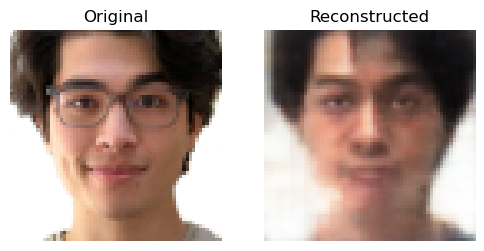

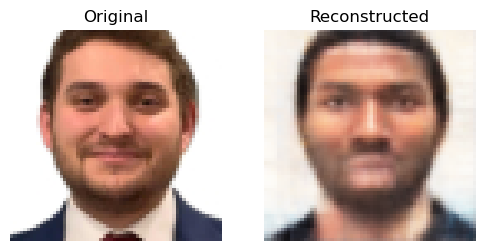

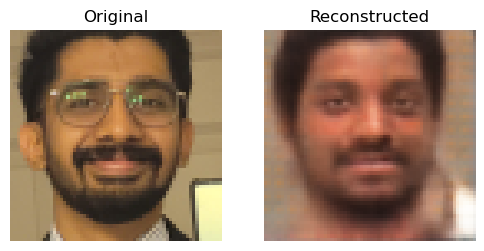

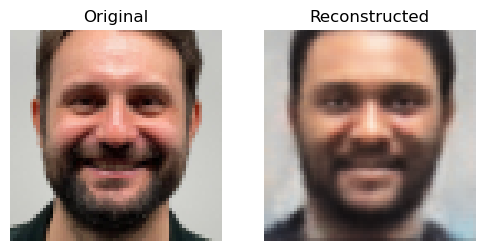

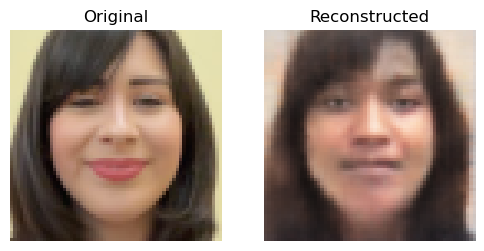

In [7]:
model.eval()
with torch.no_grad():
    for i in range(5):
        img, cond = val_dataset[i]
        img = img.unsqueeze(0).to(device)
        cond = cond.unsqueeze(0).to(device)
        recon, _, _ = model(img, cond)

        orig_np = (img.squeeze().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
        recon_np = (recon.squeeze().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(orig_np)
        plt.title("Original")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(recon_np)
        plt.title("Reconstructed")
        plt.axis("off")
        plt.show()

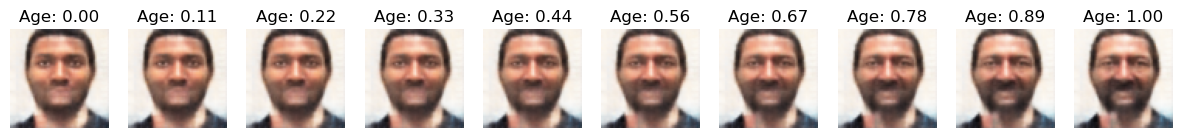

In [9]:
def generate_age_variation(model, image, cond, age_values):
    """
    Given an image and its condition, encode it and then decode it
    with varying age conditions.

    Args:
        model: Trained ConditionalVAE.
        image: A single image tensor (C x H x W).
        cond: Its corresponding condition tensor (age), shape [1].
        age_values: Iterable of new normalized age values.

    Returns:
        List of generated images (tensors).
    """
    model.eval()
    outputs = []
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        cond = cond.unsqueeze(0).to(device)

        mu, logvar = model.encoder(image, cond)
        z = reparameterize(mu, logvar)
        for age in age_values:
            new_cond = torch.tensor([[age]], dtype=torch.float32).to(device)
            out = model.decoder(z, new_cond)
            outputs.append(out)
    return outputs

sample_img, sample_cond = test_dataset[1]
age_range = np.linspace(0.0, 1.0, 10)
generated_images = generate_age_variation(model, sample_img, sample_cond, age_range)

plt.figure(figsize=(15, 3))
for i, gen in enumerate(generated_images):
    gen_np = (gen.squeeze().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
    plt.subplot(1, len(generated_images), i+1)
    plt.imshow(gen_np)
    plt.title(f"Age: {age_range[i]:.2f}")
    plt.axis("off")
plt.show()